<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

## <center> Assignment 4. Sarcasm detection with logistic regression
    
We'll be using the dataset from the [paper](https://arxiv.org/abs/1704.05579) "A Large Self-Annotated Corpus for Sarcasm" with >1mln comments from Reddit, labeled as either sarcastic or not. A processed version can be found on Kaggle in a form of a [Kaggle Dataset](https://www.kaggle.com/danofer/sarcasm).

Sarcasm detection is easy. 
<img src="https://habrastorage.org/webt/1f/0d/ta/1f0dtavsd14ncf17gbsy1cvoga4.jpeg" />

In [1]:
# !dir

In [2]:
import os
import numpy as np
import pandas as pd
from pandas.api.types import is_integer_dtype
import re
import ast
import scipy

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

# from nltk.corpus import stopwords  # less intrusive than TfidfVectorizer ~ 180
# from nltk.corpus import words as eng_words
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS  # # less intrusive than TfidfVectorizer ~ 192
from sklearn.feature_extraction.text import TfidfVectorizer  # built in stopwords - over 300

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix

import eli5  # if problems with import: https://github.com/eli5-org/eli5/issues/39 and https://github.com/eli5-org/eli5/compare/master...RobertCarruthers-Ki:eli5:update-sklearn


In [3]:
PATH_TO_DATA = '../input/sarcasm/train-balanced-sarcasm.csv'

In [4]:
train_df = pd.read_csv(PATH_TO_DATA)

In [5]:
train_df.head(2)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...


In [6]:
train_df.shape

(1010826, 10)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010771 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


Some comments are missing, so we drop the corresponding rows.

In [8]:
train_df.dropna(subset=['comment'], inplace=True)

We notice that the dataset is indeed balanced

In [9]:
train_df['label'].value_counts()

label
0    505403
1    505368
Name: count, dtype: int64

In [10]:
train_df.describe()

,label,score,ups,downs
count,1.010771e+06,1.010771e+06,1.010771e+06,1.010771e+06
mean,4.999827e-01,6.886007e+00,5.499149e+00,-1.458679e-01
std,5.000002e-01,4.834416e+01,4.127406e+01,3.529739e-01
min,0.000000e+00,-5.070000e+02,-5.070000e+02,-1.000000e+00
25%,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00
75%,1.000000e+00,4.000000e+00,3.000000e+00,0.000000e+00
max,1.000000e+00,9.070000e+03,5.163000e+03,0.000000e+00


We split data into training and validation parts.

In [11]:
train_texts, valid_texts, y_train, y_valid = \
        train_test_split(train_df['comment'], train_df['label'], random_state=17)

## Tasks:
1. Analyze the dataset, make some plots. This [Kernel](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) might serve as an example
2. Build a Tf-Idf + logistic regression pipeline to predict sarcasm (`label`) based on the text of a comment on Reddit (`comment`).
3. Plot the words/bigrams which a most predictive of sarcasm (you can use [eli5](https://github.com/TeamHG-Memex/eli5) for that)
4. (optionally) add subreddits as new features to improve model performance. Apply here the Bag of Words approach, i.e. treat each subreddit as a new feature.

## Links:
  - Machine learning library [Scikit-learn](https://scikit-learn.org/stable/index.html) (a.k.a. sklearn)
  - Kernels on [logistic regression](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-2-classification) and its applications to [text classification](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-4-more-of-logit), also a [Kernel](https://www.kaggle.com/kashnitsky/topic-6-feature-engineering-and-feature-selection) on feature engineering and feature selection
  - [Kaggle Kernel](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle) "Approaching (Almost) Any NLP Problem on Kaggle"
  - [ELI5](https://github.com/TeamHG-Memex/eli5) to explain model predictions

## 1. EDA (paša)

In [12]:
sns.set(rc={'figure.figsize': (12,6)}, style='whitegrid', palette='viridis')

def random_color():
    """
    return random matplot-lib colour
    """
    return mcolors.get_named_colors_mapping().popitem()[1]

In [13]:
top_10_subr_columns = train_df["subreddit"].value_counts()[:10].index

In [14]:
top_10_subredits_filter = train_df[train_df["subreddit"].isin(top_10_subr_columns)].astype(str)  # atrast kur te inti...

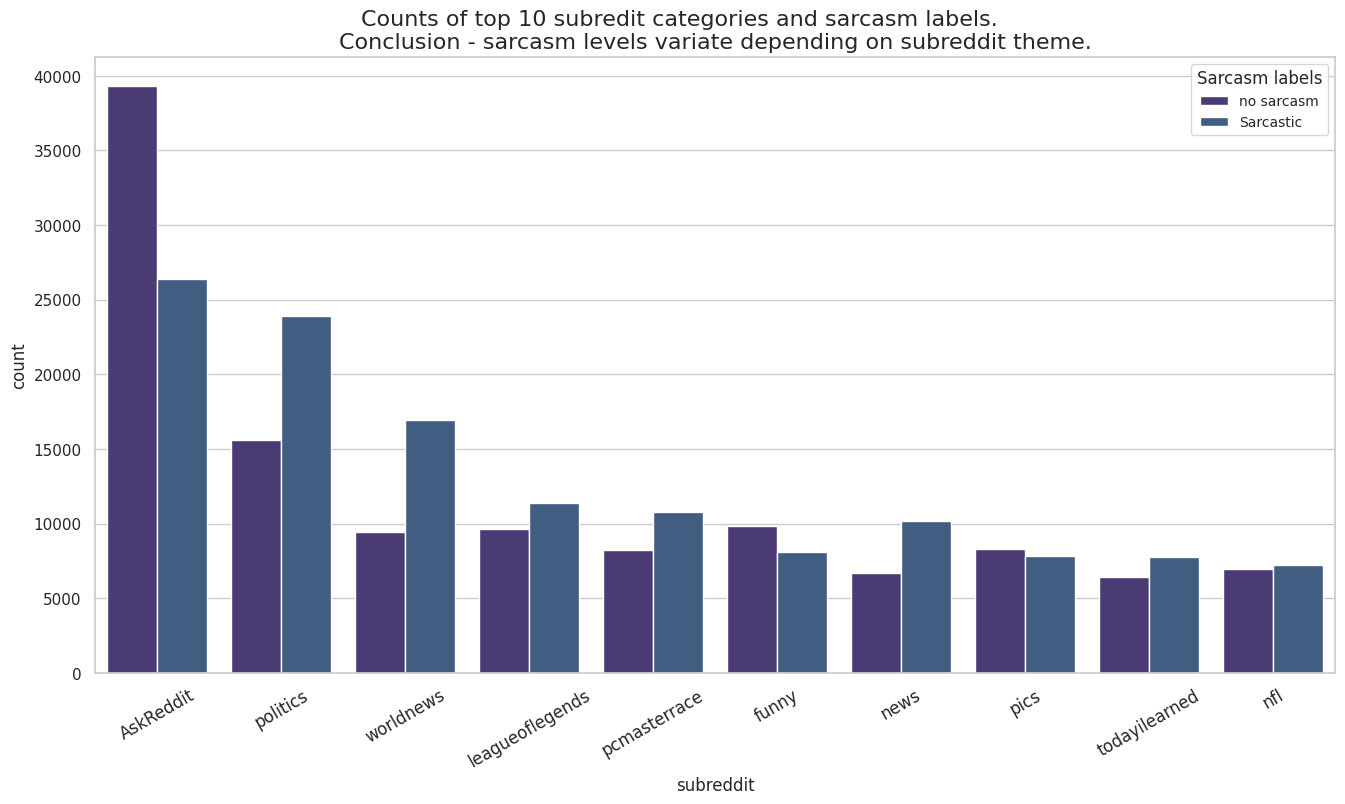

In [15]:
plt.figure(figsize=(16, 8))
sns.countplot(data=top_10_subredits_filter, 
               x = "subreddit", 
               hue="label",
               order=top_10_subr_columns)
plt.xticks(rotation=30, fontsize=12)
plt.title("Counts of top 10 subredit categories and sarcasm labels.\
          \nConclusion - sarcasm levels variate depending on subreddit theme.", fontsize=16)
plt.legend(title="Sarcasm labels", labels=["no sarcasm", 'Sarcastic'], fontsize=10)
plt.show()

In [16]:
train_df["comment_lenght_chars"] = train_df["comment"].apply(lambda text: len(text))

In [17]:
upper_bound_percentile = np.percentile(train_df['comment_lenght_chars'], 100 - (100 - 95.4) / 2)
lower_bound_percentile = np.percentile(train_df['comment_lenght_chars'], (100 - 95.4) / 2)

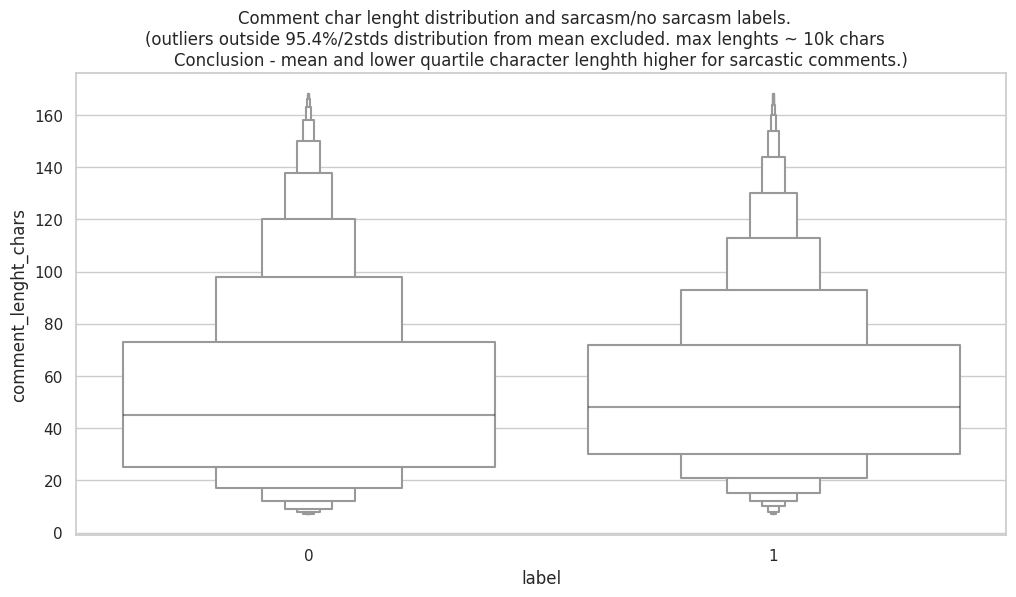

In [18]:
sns.boxenplot(data=train_df[(train_df['comment_lenght_chars'] > lower_bound_percentile) & 
                          (train_df['comment_lenght_chars'] < upper_bound_percentile)], 
                          x="label", y='comment_lenght_chars', 
                          color=random_color())
plt.title(f"Comment char lenght distribution and sarcasm/no sarcasm labels.\
          \n(outliers outside 95.4%/2stds distribution from mean excluded. max lenghts ~ 10k chars\
          \nConclusion - mean and lower quartile character lenghth higher for sarcastic comments.)", 
          loc="center")
plt.show()

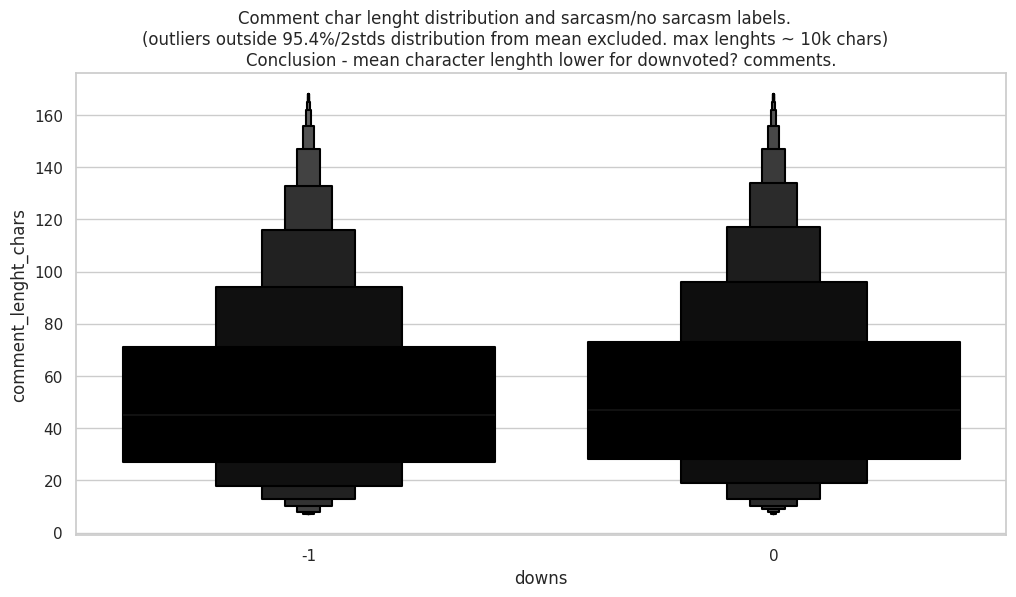

In [19]:
sns.boxenplot(data=train_df[(train_df['comment_lenght_chars'] > lower_bound_percentile) & 
                          (train_df['comment_lenght_chars'] < upper_bound_percentile)], 
                          x="downs", y='comment_lenght_chars',
                          color=random_color())
plt.title(f"Comment char lenght distribution and sarcasm/no sarcasm labels.\
          \n(outliers outside 95.4%/2stds distribution from mean excluded. max lenghts ~ 10k chars)\
          \nConclusion - mean character lenghth lower for downvoted? comments.", 
          loc="center")
plt.show()

In [20]:
number_columns = [column for column in train_df.columns if is_integer_dtype(train_df[column])]
number_columns

['label', 'score', 'ups', 'downs', 'comment_lenght_chars']

In [21]:
train_df[number_columns].head(2)

,label,score,ups,downs,comment_lenght_chars
0,0,2,-1,-1,10
1,0,-4,-1,-1,74


In [22]:
sns.__version__

'0.12.2'

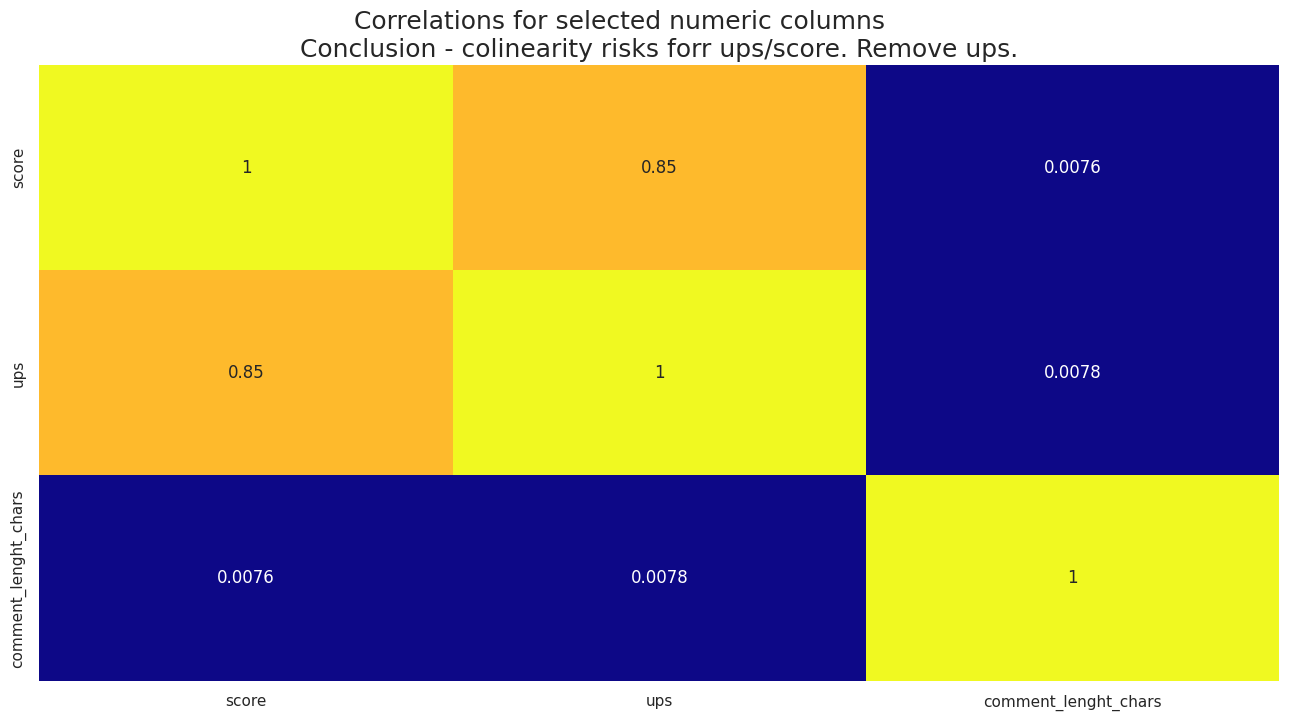

In [23]:
plt.figure(figsize=(16, 8))
sns.heatmap(train_df[['score', 'ups', 'comment_lenght_chars']].corr(), 
            annot=True, cbar=False, cmap='plasma')
plt.title(f'Correlations for selected numeric columns\
          \nConclusion - colinearity risks forr ups/score. Remove ups.', fontsize=18)
plt.show()

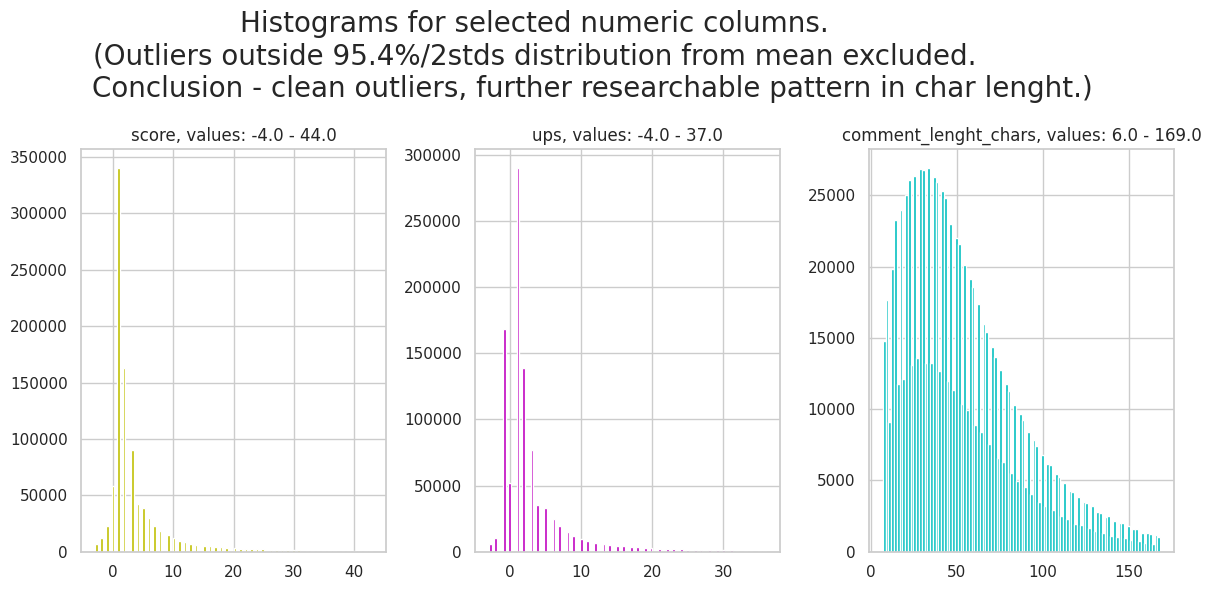

In [24]:
selected_num_columns = ['score', 'ups', 'comment_lenght_chars']
fig, axs = plt.subplots(ncols=len(selected_num_columns), 
                        figsize = (12,6))

loc=0
for column in selected_num_columns:
    upper_bound_value = np.percentile(train_df[column], 100 - (100 - 95.4) / 2)
    lower_bound_value= np.percentile(train_df[column], (100 - 95.4) / 2)
    axs[loc].hist(x=column, 
                  data=train_df[(train_df[column] > lower_bound_value) & 
                        (train_df[column] < upper_bound_value)],
                    bins=100, 
                    color = random_color())  # ja sns, ax=axs[loc] iekš iekavām
    axs[loc].set_title(f"{column}, values: {lower_bound_value} - {upper_bound_value}")
    loc += 1
    

fig.suptitle('Histograms for selected numeric columns.\
             \n(Outliers outside 95.4%/2stds distribution from mean excluded.\
             \nConclusion - clean outliers, further researchable pattern in char lenght.)', fontsize=20)
plt.tight_layout()

### remove 'ups'

In [25]:
train_df.drop('ups', axis=1, inplace=True)

#### clean values outside 2 stds from mean for 'score', 'comment_lenght_chars' feature

In [26]:
selected_num_columns = ['score', 'ups', 'comment_lenght_chars']


def clean_tail_values(data=train_df, features=selected_num_columns,  percent_to_keep = 95.4): 
    """
    Drop tail values for rows of specified DataFrame columns.
    """
    for col in features:
        upper_bound = np.percentile(data[col], 100 - (100 - percent_to_keep) / 2)
        lower_bound= np.percentile(data[col], (100 - percent_to_keep) / 2)
        data = data[(data[col] > lower_bound) & 
                        (data[col] < upper_bound)]
    return data



In [27]:
rows_before_clean = len(train_df)
rows_before_clean

1010771

In [28]:
selected_num_columns = ['score', 'comment_lenght_chars']

train_df = clean_tail_values(features=selected_num_columns)

rows_after_clean = len(train_df)
removed_row_proportion = 1 - (rows_after_clean / rows_before_clean)
removed_row_proportion

0.09666976990831755

### EDA on words

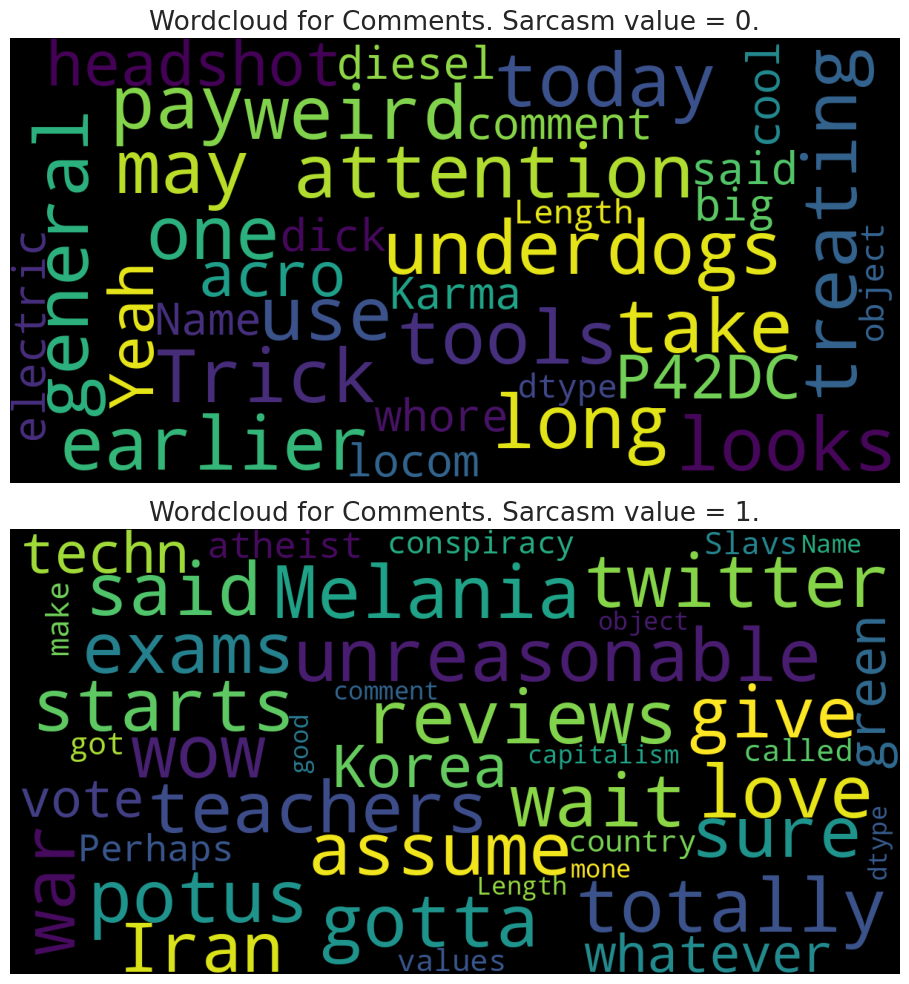

In [29]:
wordcloud = WordCloud(width = 1200, height = 600,  # https://amueller.github.io/word_cloud/cli.html
                    background_color= random_color(), #'black',
                    stopwords = STOPWORDS,
                    min_word_length = 3,
                    max_words = 200,
                    max_font_size = 100,
                    min_font_size = 10,
                    random_state = 17,
                )

target_values = train_df["label"].unique()

fig, axs = plt.subplots(figsize=(12,10), nrows=len(target_values))

for index, value in enumerate(target_values):
    wordcloud.generate(str(train_df.loc[train_df['label'] == value, 'comment']))
    axs[index].imshow(wordcloud)
    axs[index].set_title(f"Wordcloud for Comments. Sarcasm value = {value}.", 
                         fontsize=19)
    axs[index].axis('off')
plt.tight_layout()

In [30]:
def pre_process_text(comment):
    """
    1. convert to lowercase
    2. remove website references(http and .com containing phrases) 
    3. remove punctiation and numbers
    6. remove short tokens
    # 7. remove duplicate tokens
    # 8. count words in input string 
    9. join list into string
    10. return string of pre-processd words separated by whitespace
    """
    
    low = comment.lower()
    no_web = re.sub(r'http\S+|www\.\S+|\S*.com\S+', '', low)
    nopunk = re.sub(r'[^a-zA-Z]', ' ', no_web)
    no_white = re.sub(r'^\s*|\s\s*', ' ', nopunk).strip()
    tokens = no_white.split()
    # return [word for word in tokens if len(word) > 1]
    no_short_words = [word for word in tokens if len(word) > 1]
    # removed_duplicates = list(set(no_short_words))
    
    # word_count = len(no_short_words)
    
    joined_output = ' '.join(no_short_words)
    
    return joined_output #, word_count

In [31]:
%%time
train_df["comment_words"] = train_df["comment"].apply(pre_process_text)

CPU times: user 18 s, sys: 116 ms, total: 18.1 s
Wall time: 18.2 s


CPU times: user 15.1 s, sys: 1.15 s, total: 16.2 s
Wall time: 15.8 s


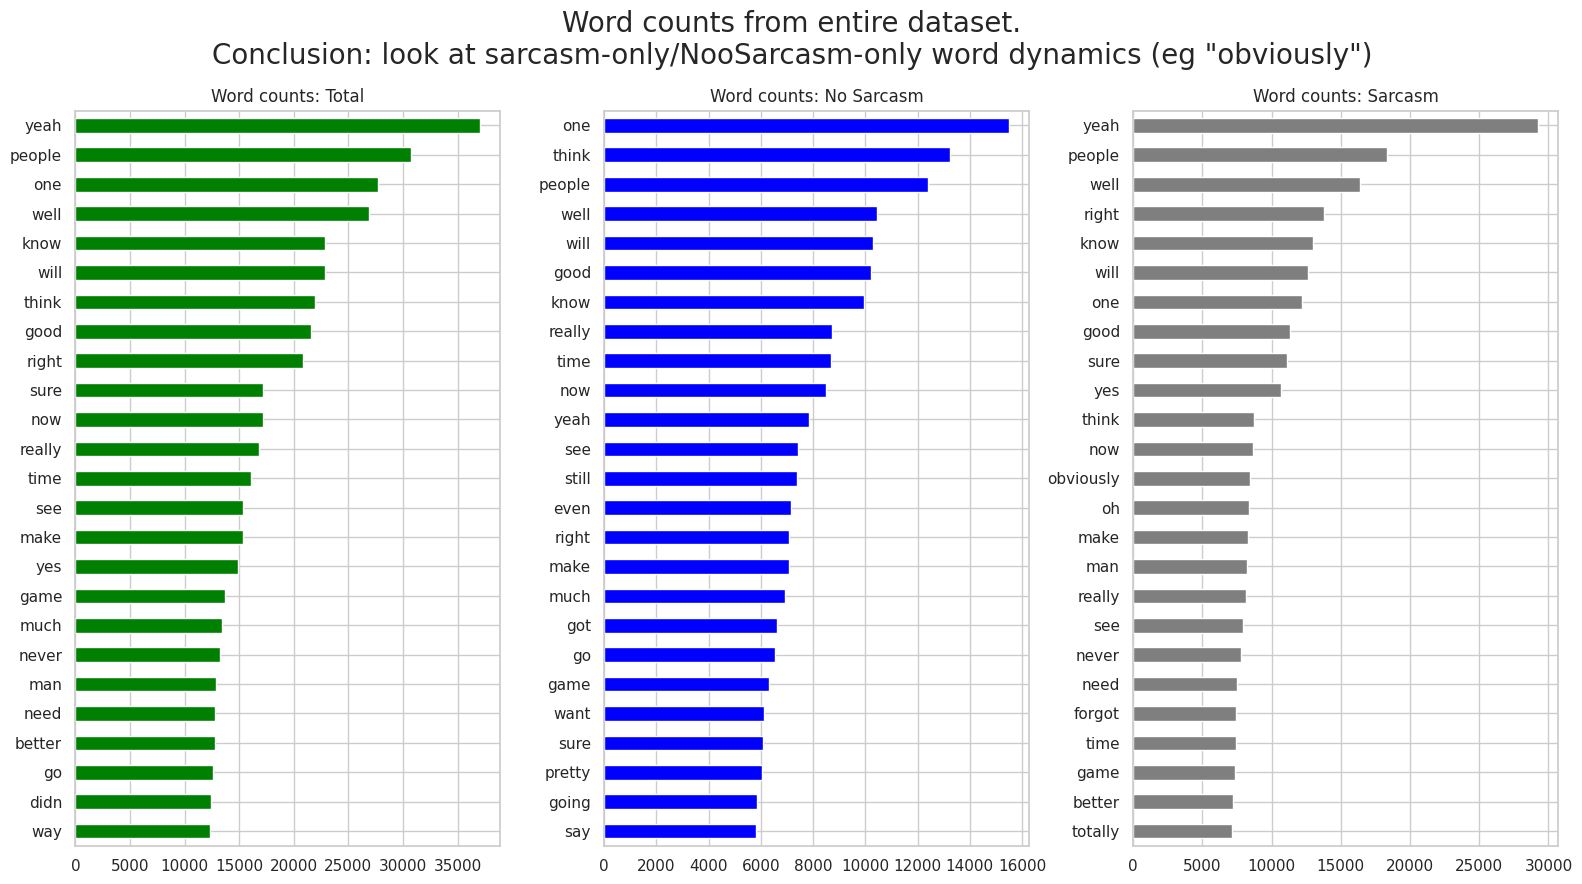

In [32]:
%%time

stopwords_own = ['don', "ll", "re", "ve", ]
stopword_ext = list(STOPWORDS)
stopwords_own.extend(list(STOPWORDS))

word_counts_total = pd.Series(map(str.split, train_df['comment_words'])).explode().value_counts()   # create series where each word is one row

word_counts_total.drop(stopwords_own, inplace=True, errors='ignore')  # remove stopwords 

grouped_tokens = train_df.groupby("label")['comment_words']
grouped_tokens.groups

fig, axs = plt.subplots(ncols=3, figsize = (16,9))

word_counts_total.head(25).sort_values().plot(kind='barh', color = random_color(), ax=axs[0])
axs[0].set_title("Word counts: Total")

loc = 1
for key, group in grouped_tokens:
    
    single_word_series = pd.Series(map(str.split, group)).explode().value_counts()
    single_word_series.drop(stopwords_own, inplace=True, errors='ignore')  # remove stopwords
    single_word_series.head(25).sort_values().plot(kind='barh', color = random_color(), ax=axs[loc])
    if key == 0:
        axs[loc].set_title("Word counts: No Sarcasm")
    else:
        axs[loc].set_title("Word counts: Sarcasm")
    loc += 1

fig.suptitle('Word counts from entire dataset.\nConclusion: look at sarcasm-only/NooSarcasm-only word dynamics (eg "obviously")', fontsize=20)

plt.tight_layout()

In [33]:
%%time
# Get word counts that are specific for sarcastic comments - top 200 words for non-sarcastic comments removed
sarc_word_count = pd.Series(map(str.split, train_df[train_df["label"] == 1]["comment_words"])).explode().value_counts().head(200)
no_sarc_word_count = pd.Series(map(str.split, train_df[train_df["label"] == 0]["comment_words"])).explode().value_counts().head(200)
sarcasm_only_words = [word for word in list(sarc_word_count.index) if word not in list(no_sarc_word_count.index)]
sarc_only_value_count = pd.Series(map(str.split, train_df[train_df["label"] == 1]["comment_words"])).explode().value_counts()[sarcasm_only_words]
sarc_only_value_count

CPU times: user 12.1 s, sys: 137 ms, total: 12.3 s
Wall time: 12.3 s


obviously     8434
forgot        7448
totally       7105
clearly       5870
must          5791
wow           4962
white         4937
guys          4405
women         4370
such          4190
money         4135
racist        3782
god           3766
black         3608
nah           3538
nothing       3476
world         3442
stop          3422
wait          3349
hey           3333
wrong         3315
reddit        3298
yea           3222
definitely    3068
aren          3020
free          2998
cause         2982
men           2976
op            2975
course        2917
Name: count, dtype: int64

## 2. Build a Tf-Idf + logistic regression pipeline to predict sarcasm.

##### create a dictionary of all the words (+bigrams) with TfidfVectorizer

In [34]:
tfidf_unibi_p = TfidfVectorizer(
#     stop_words=stopwords_own, beeter accuracy w/o removing stopwords
    max_features=50000,
    min_df=2,
    ngram_range=(1, 2))  # default=(1, 1) - unigrams only,

log_reg = LogisticRegression(solver="lbfgs", n_jobs=-1, random_state=17)

    
pipeline_lr_unibigr = make_pipeline(
    tfidf_unibi_p,
    log_reg
)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df[['comment_words', "subreddit"]],
    train_df["label"], 
    test_size=0.2, 
    random_state=17
)

In [36]:
for dataset in [X_train, X_test, y_train, y_test]:
    print(dataset.shape)

(730448, 2)
(182612, 2)
(730448,)
(182612,)


In [37]:
%%time
pipeline_lr_unibigr.fit(X_train['comment_words'], y_train)
predictions = pipeline_lr_unibigr.predict(X_test['comment_words'])
print(pipeline_lr_unibigr.score(X_test['comment_words'], y_test))

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7165027489978752
CPU times: user 40.4 s, sys: 1 s, total: 41.4 s
Wall time: 55.9 s


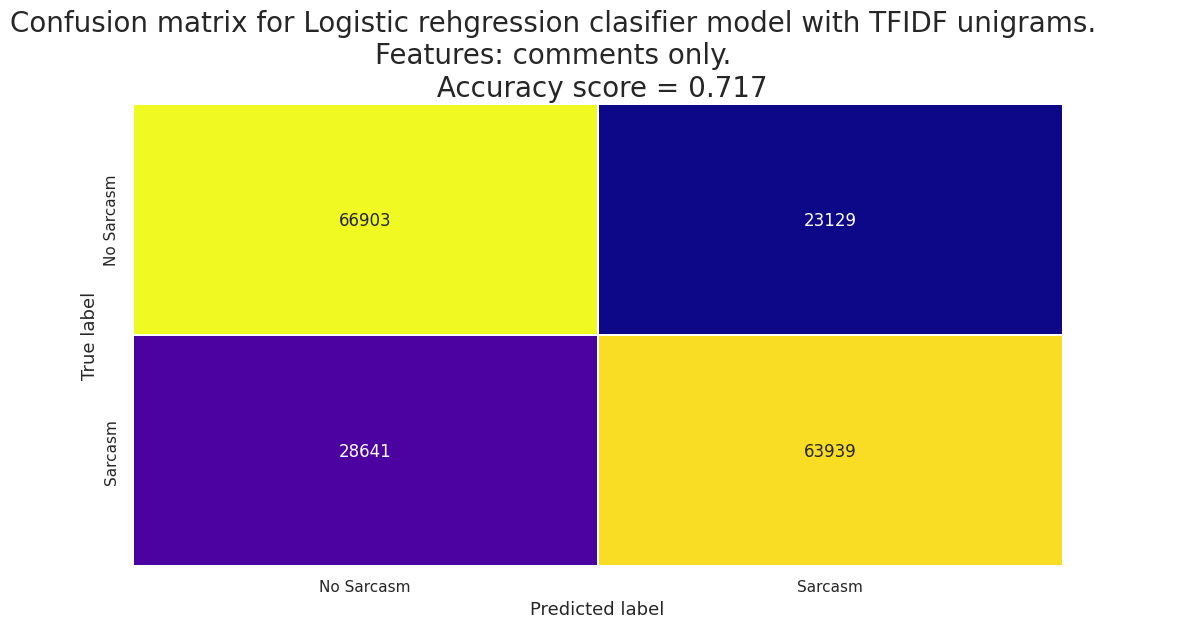

In [38]:
acc_score = accuracy_score(y_true=y_test, y_pred=predictions)

sns.heatmap(confusion_matrix(y_test, predictions,), annot=True, linewidths=0.1, cbar=False,   #  normalize='true'
            yticklabels=['No Sarcasm', 'Sarcasm'],
            xticklabels=['No Sarcasm', 'Sarcasm'], 
            cmap='plasma',
           fmt='d')

plt.ylabel('True label', fontsize=13)
plt.xlabel('Predicted label', fontsize=13)
plt.title(f'Confusion matrix for Logistic rehgression clasifier model with TFIDF unigrams.\
          \nFeatures: comments only.\
          \n Accuracy score = {round(accuracy_score(y_true=y_test, y_pred=predictions), 3)}',
        fontsize=20)
plt.show()

### 3. Plot the words/bigrams which a most predictive of sarcasm ([eli5](https://github.com/TeamHG-Memex/eli5))


In [39]:
%%time
eli5.show_weights(
    log_reg, 
    feature_names=tfidf_unibi_p.get_feature_names_out(),
    # target_names=(["sarc", "no sarc"]),
    top=25
)

CPU times: user 138 ms, sys: 13.9 ms, total: 152 ms
Wall time: 156 ms


Weight?,Feature
+8.032,obviously
+7.898,yes because
+7.864,clearly
+7.157,totally
+6.515,yeah because
+5.827,because
+5.797,gee
+5.626,yeah
+5.607,right because
+5.588,but thought


### 4. Add subreddits as new features to improve model performance. Apply here the Bag of Words approach, i.e. treat each subreddit as a new feature.

In [40]:
train_df["subreddit"].nunique()

14415

In [41]:
tfidf_subred = TfidfVectorizer()

In [42]:
%%time
X_train = scipy.sparse.hstack((tfidf_unibi_p.fit_transform(X_train["comment_words"]), tfidf_subred.fit_transform(X_train["subreddit"])))
X_test = scipy.sparse.hstack((tfidf_unibi_p.transform(X_test["comment_words"]), tfidf_subred.transform(X_test["subreddit"])))
X_train.shape, X_test.shape

CPU times: user 38.4 s, sys: 814 ms, total: 39.2 s
Wall time: 39.2 s


((730448, 63160), (182612, 63160))

In [43]:
%%time
log_reg.fit(X_train, y_train)
predictions_comm_subred = log_reg.predict(X_test)
round(log_reg.score(X_train, y_train), 3), round(log_reg.score(X_test, y_test), 3)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CPU times: user 330 ms, sys: 84.9 ms, total: 415 ms
Wall time: 14.1 s


(0.75, 0.722)

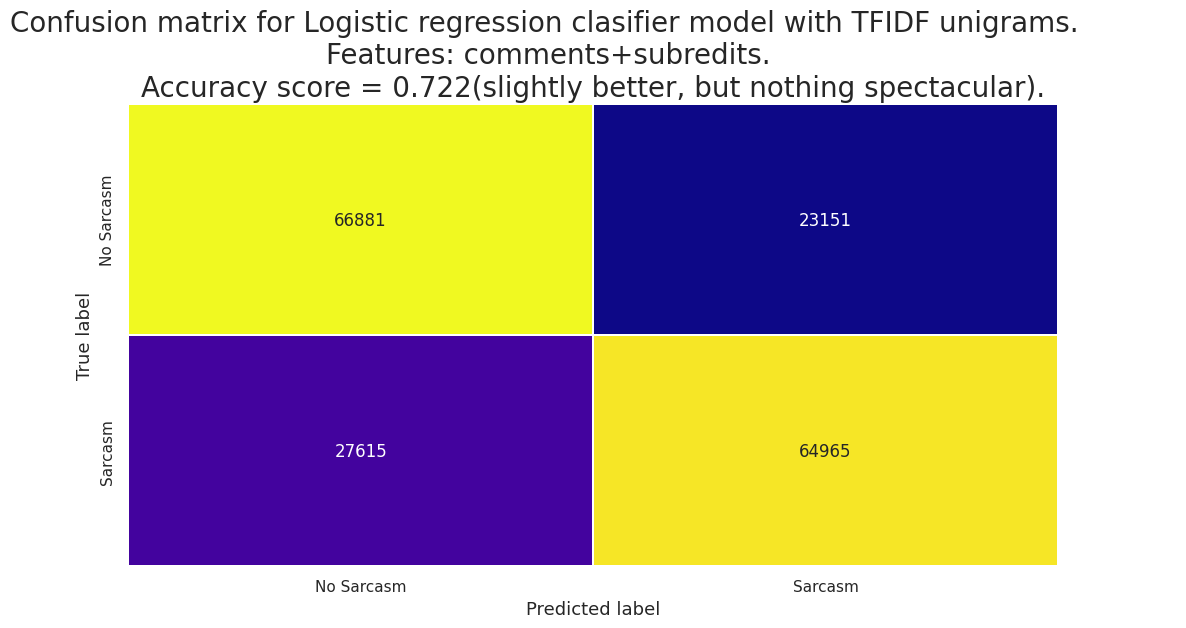

In [44]:
acc_score = accuracy_score(y_true=y_test, y_pred=predictions_comm_subred)

sns.heatmap(confusion_matrix(y_test, predictions_comm_subred), annot=True, linewidths=0.1, cbar=False,   #  normalize='true'
            yticklabels=['No Sarcasm', 'Sarcasm'],
            xticklabels=['No Sarcasm', 'Sarcasm'], cmap='plasma',
           fmt='d')

plt.ylabel('True label', fontsize=13)
plt.xlabel('Predicted label', fontsize=13)
plt.title(f'Confusion matrix for Logistic regression clasifier model with TFIDF unigrams.\
           \nFeatures: comments+subredits.\
          \nAccuracy score = {round(accuracy_score(y_true=y_test, y_pred=predictions_comm_subred), 3)}\
(slightly better, but nothing spectacular).',
              fontsize=20)
plt.show()